# Legacy notebook
Contains code for getting NER and sentiment before I function-ified everything

In [6]:
%%time
nov_df = pd.read_csv('data/201711-comments_submissions.tsv.gz', sep = '\t', encoding = 'utf-8')
dec_df = pd.read_csv('data/201712-comments_submissions.tsv.gz', sep = '\t', encoding = 'utf-8')
jan_df = pd.read_csv('data/201801-comments_submissions.tsv.gz', sep = '\t', encoding = 'utf-8')
feb_df = pd.read_csv('data/201802-comments_submissions.tsv.gz', sep = '\t', encoding = 'utf-8')
mar_df = pd.read_csv('data/201803-comments_submissions.tsv.gz', sep = '\t', encoding = 'utf-8')
apr_df = pd.read_csv('data/201804-comments_submissions.tsv.gz', sep = '\t', encoding = 'utf-8')

C:\Anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
combo_df = pd.concat([dec_df, jan_df, feb_df, mar_df]).dropna(subset=['text'])
print(combo_df.shape)
combo_df.tail(2)

(2515906, 6)


,Unnamed: 0,flair,source,text,timestamp,user
700461,NaN,Rockets,comment,Never said I was smart lol.,1.52246e+09,splanket
700462,NaN,[CHI] Jimmy Butler,comment,"Wrong use of this, nice try though I guess",1.52246e+09,DevsiK


In [4]:
combo_df['text_length'] = combo_df['text'].str.len()

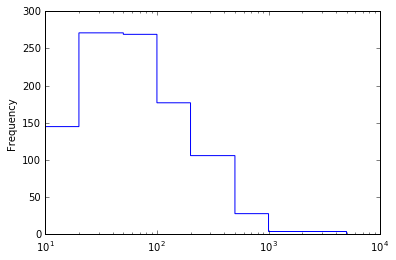

In [5]:
combo_df['text_length'].sample(1000).plot.hist(histtype ='step', bins = [0, 20, 50, 100, 200, 500, 1000, 5000]);
plt.xscale('log')

In [6]:
combo_df = combo_df.query('text_length > 40')
combo_df.shape

(1710957, 7)

#### Save / load combined months

In [20]:
combo_df = pd.read_csv('data/combined_months.tsv',
                       sep ='\t', compression = 'gzip', encoding ='utf-8')

C:\Anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
combo_df = combo_df.query('text_length > 20 and text_length < 500')
combo_df.shape

(1638077, 7)

#### Parse into sentences

In [22]:
%%time
sentences_df = (pd.DataFrame(combo_df.text.apply(sent_tokenize).tolist(), index=combo_df.index)
                  .stack() )
sentences_df = (sentences_df.reset_index()
                  .set_index('level_0')
                  .rename(columns={0:'sentences'})
                  .drop('level'))
sentences_df['sentences'] = sentences_df['sentences'].str.replace('\r|\n', ' ')

C:\Anaconda3\Lib\site-packages\numpy\lib\arraysetops.py:379: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Wall time: 3min 53s


In [23]:
combo_df = combo_df.join(sentences_df)#[['user', 'flair', 'source', 'sentences', 'timestamp']]
combo_df.shape

(3136391, 9)

#### Save / load

In [95]:
combo_df = pd.read_csv('combined_months_sentences.tsv.gz',
                       sep = '\t', compression ='gzip', encoding='utf-8')
combo_df = combo_df[combo_df.sentences.str.len() > 10]

C:\Anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Identify named entities

In [73]:
tagger = Ner(host='localhost',port=9199)
# download stanford core nlp (should be a zip file of format stanford-ner-YYYY-MM-DD) (maybe from https://nlp.stanford.edu/software/CRF-NER.shtml#Download)
# need to start the Java server:
# cd C:\ProgramData\Anaconda3\Lib\site-packages\sner\stanford-ner-2018-02-27
# java -Djava.ext.dirs=./lib -cp stanford-ner.jar edu.stanford.nlp.ie.NERServer -port 9199 -loadClassifier ./classifiers/english.all.3class.distsim.crf.ser.gz  -tokenizerFactory edu.stanford.nlp.process.WhitespaceTokenizer -tokenizerOptions tokenizeNLs=false

In [97]:
%%time
sner_entities = lambda text: [token for token, part in tagger.get_entities(text ) if part in {'PERSON', 'ORGANIZATION', 'LOCATION'}]
combo_df['named_entities'] = combo_df['sentences'].apply(lambda doc: sner_entities(doc))

Wall time: 2h 16min 42s


#### Save / load

In [99]:
%%time
combo_df = pd.read_csv('combined_months_ner.tsv.gz', sep='\t', compression='gzip',
                      encoding ='utf-8')

<string>:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.


Wall time: 11.1 s


In [100]:
%%time
# ~ 1 min
combo_df['named_entities'] = combo_df['named_entities'].apply(literal_eval)
combo_df = combo_df[combo_df['named_entities'].str.len() > 0]
combo_df = combo_df[combo_df['sentences'].str.len() > 15]
combo_df['named_entities'] = combo_df['named_entities'].apply(lambda entities: [entity.strip(punctuation) for entity in entities])
combo_df['named_entities'] = combo_df['named_entities'].apply(lambda entities: [entity.lower() for entity in entities])

Wall time: 57.8 s


In [101]:
combo_df.shape

(766138, 6)

### Get rid of team entities

In [154]:
teams = set('Atlanta Hawks Boston Celtics Brooklyn Nets Charlotte Bobcats' \
         'Chicago Bulls Cleveland Cavaliers cavs Dallas Mavericks mavs Denver Nuggets ' \
'Detroit Pistons Golden State Warriors Houston Rockets Indiana'\
         'Pacers Los Angeles LA Clippers LA Lakers LAL Memphis Grizzlies Miami Heat '\
'Milwaukee Bucks Minnesota Timberwolves NBA New Orleans Hornets New York Knicks NYK '\
'Oklahoma City Thunder Orlando Magic Philadelphia Sixers 76ers Phoenix'\
         'Suns Portland Trail Blazers Sacramento Kings'\
'San Antonio Spurs Toronto Raptors Utah Jazz Washington Wizards wiz'.lower().split())

In [155]:
combo_df['named_entities'] = combo_df['named_entities'].apply(lambda entities: [entity for entity in entities if entity not in teams])
combo_df = combo_df[combo_df['named_entities'].str.len() > 0]
combo_df = combo_df[combo_df['named_entities'].str.len() <3]
combo_df.shape

(450420, 12)

### Sentiment scoring

In [150]:
%%time
intermediate_df = combo_df['sentences'].apply(lambda sentence: sid.polarity_scores(sentence) )
sentiment_df = pd.DataFrame.from_dict(intermediate_df.tolist())

Wall time: 2min 31s


In [153]:
combo_df = combo_df.join(sentiment_df)
combo_df.head()

,user,flair,source,sentences,timestamp,named_entities,str_entities,fuzzy_name,compound,neg,neu,pos
0,EmNightShyamalan,[LAL] Julius Randle,submission,Is there a mediocre NBA player who has a deceptively impressive highlight reel?,1.512227e+09,[nba],nba,unclear,0.6908,0.0,0.612,0.388
1,Mithridates12,[CLE] LeBron James,submission,Do you think the NBA will at some change the rule in favor of the defense?.,1.512212e+09,[nba],nba,unclear,0.4019,0.0,0.847,0.153
2,Nickelas,Mavericks,submission,"Random Idea: Why hasn't the NBA thought to do an annual ""ABA Night""?.",1.512209e+09,[nba],nba,unclear,0.0000,0.0,1.000,0.000
3,Nickelas,Mavericks,submission,"The NBA could pick a Sunday and have a back-to-back nationally televised night: a combination of the Spurs, Pacers, Nets, and Nuggets.",1.512209e+09,[nba],nba,unclear,0.0000,0.0,1.000,0.000
4,jallain,[BOS] Paul Pierce,submission,"According to NBA.com, the Atlanta Hawks are currently the only team in the NBA averaging more passes received per game (327.7) than passes made (327.4).",1.512209e+09,[nba],nba,unclear,0.0000,0.0,1.000,0.000


#### Make sure positive and negative sentiment are directional

In [90]:
pd.set_option('display.max_colwidth', 400)
combo_df.query('neg< -0.1 and pos > 0.1')[['sentences', 'pos', 'neg']].tail(200).head(10).values

array([['And Rose was the worst of those 3.', 0.369, -0.6249],
       [ 'I think this is a little unfair of Windhorst to bring up a private conversation he supposedly had with Lebron years ago though.',
        0.129, -0.4228],
       [ 'He is admitting that Rose deserved it in 2011 and was upset with himself that he let someone outplay him.',
        0.12, -0.3818],
       [ 'Windhorst talking out of his ass (as he usually does on LeBron) and everyone on here taking it as if LeBron said it himself',
        0.132, -0.5423],
       [ 'I always thought it was the second Nash MVP that people had a problem with.',
        0.184, -0.4019],
       [ "Not undermining Rose's achievements, but without Dwight that team is awful.",
        0.39, -0.6956],
       [ 'I think the 2 years he concedes are obviously Curry in 2016, Steph broke basketball that year, and KD in 2014.',
        0.135, -0.4215],
       ['Probably the weakest since Nash actually.', 0.39799999999999996,
        -0.5106],
    

In [10]:
combo_df = pd.read_csv('data/combined_months_ner_sentiment.tsv.gz', compression = 'gzip',
                       encoding = 'utf-8')
combo_df['named_entities'] = combo_df['named_entities'].apply(literal_eval)

In [11]:
combo_df.shape

(450420, 12)